In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import session_info

## Load data

In [2]:
# Read data
df = pd.ExcelFile('Base de dados Case.xlsx')
df.sheet_names

['Instruções', 'Populacao_Estado', 'De_para_UF', 'PIB_municipio', 'UF_Regiao']

In [3]:
# sheet_names = df.sheet_names[1:]
# all_df = {key.lower():value for key, value in zip(sheet_names, [df.parse(sheet) for sheet in sheet_names])}

populacao_estado_df = df.parse('Populacao_Estado')
uf_df = df.parse('De_para_UF')
pib_municipio_df = df.parse('PIB_municipio')
uf_regiao = df.parse('UF_Regiao')

## Feature analysis

### `Populacao_Estado`

In [4]:
populacao_estado_df.head()

,Granularidade,fx_idade,Populacao
0,Brasil,Total,190755799
1,Brasil,0 a 4 anos,13806733
2,Brasil,5 a 9 anos,14967767
3,Brasil,10 a 14 anos,17167135
4,Brasil,15 a 19 anos,16986788


In [5]:
print('Unique values for Granularidade:')
print(populacao_estado_df['Granularidade'].sort_values().unique())
print(f'Number of unique values: {populacao_estado_df["Granularidade"].nunique()}')

Unique values for Granularidade:
['Acre' 'Alagoas' 'Amapa' 'Amazonas' 'Bahia' 'Brasil' 'Ceara'
 'Distrito Federal' 'Espirito Santo' 'Goias' 'Maranhao' 'Mato Grosso'
 'Mato Grosso do Sul' 'Minas Gerais' 'Para' 'Paraiba' 'Parana'
 'Pernambuco' 'Piaui' 'Rio Grande do Norte' 'Rio Grande do Sul'
 'Rio de Janeiro' 'Rondonia' 'Roraima' 'Santa Catarina' 'Sao Paulo'
 'Sergipe' 'Tocantins']
Number of unique values: 28


Estados(26) + DF + brasil (Total)

In [6]:
# Checking number of population by Brasil vs sum of others
(
populacao_estado_df
.query('Granularidade != "Brasil"')
.groupby('Granularidade')['Populacao']
.sum().sum()
) - populacao_estado_df.groupby('Granularidade').sum().loc['Brasil']

Populacao   -3
Name: Brasil, dtype: int64

In [7]:
# 
_total_fx_idade = (
populacao_estado_df
.query('fx_idade != "Total"')
.groupby('Granularidade', as_index=False)
[['Granularidade', 'Populacao']]
.sum()
.values[:,1]
)
_sum_fx_idade = (
populacao_estado_df
.query('fx_idade == "Total"')
[['Granularidade', 'Populacao']]
.sort_values('Granularidade')
.values[:,1]
)

_total_fx_idade - _sum_fx_idade

array([-1, -1, 1, 0, 0, 1, 2, 0, 1, -1, -2, 0, 0, -2, 0, 0, -1, 1, 2, 0,
       0, 0, -1, -1, 2, -1, 0, 0], dtype=object)

### `De_para_UF`

In [8]:
uf_df.head()

,Granularidade,UF,Cod_Identificacao
0,Acre,AC,12
1,Alagoas,AL,27
2,Amapa,AP,16
3,Amazonas,AM,13
4,Bahia,BA,29


In [9]:
uf_df.describe(include='object')

,Granularidade,UF
count,28,28
unique,27,26
top,Distrito Federal,DF
freq,2,2


In [10]:
uf_df[uf_df.duplicated('UF', keep=False)]

,Granularidade,UF,Cod_Identificacao
6,Distrito Federal,DF,53
10,Mato Grosso,MG,51
12,Minas Gerais,MG,31
27,Distrito Federal,DF,53


In [11]:
uf_df.loc[10, 'UF'] = 'MT'

In [12]:
uf_df.drop_duplicates(inplace=True)

In [13]:
uf_df.describe(include='object').loc[['count', 'unique']]

,Granularidade,UF
count,27,27
unique,27,27


In [14]:
# Cast "Cod_Identificacao" to string
uf_df['Cod_Identificacao'] = uf_df['Cod_Identificacao'].astype(str)

### `PIB_municipio`

In [15]:
pib_municipio_df.head()

,Cod_Identificacao,Municipio,PIB
0,1100015,Alta Floresta D'Oeste (RO),262077
1,1100023,Ariquemes (RO),1364694
2,1100031,Cabixi (RO),69611
3,1100049,Cacoal (RO),1186494
4,1100056,Cerejeiras (RO),222021


In [16]:
pib_municipio_df.shape

(5570, 3)

In [17]:
pib_municipio_df.dtypes

Cod_Identificacao     int64
Municipio            object
PIB                  object
dtype: object

In [18]:
# Casting PIB to int
try:
    pib_municipio_df['PIB'].astype(int)
except ValueError as error:
    print('ValueError:', error)

ValueError: invalid literal for int() with base 10: '...'


In [19]:
pib_municipio_df[pib_municipio_df['PIB'] == '...']

,Cod_Identificacao,Municipio,PIB
224,1504752,Mojuí dos Campos (PA),...
4503,4212650,Pescaria Brava (SC),...
4605,4220000,Balneário Rincão (SC),...
4923,4314548,Pinto Bandeira (RS),...
5160,5006275,Paraíso das Águas (MS),...


In [20]:
# Option 1: remove these observations
_condition = pib_municipio_df[pib_municipio_df['PIB'] == '...'].index
pib_municipio_df.drop(_condition)

# Option 2: parse with pd.to_numeric(), invalid rows will be replaced by null values
pib_municipio_df['PIB'] = pd.to_numeric(pib_municipio_df['PIB'], errors='coerce')
print('Number of NaNs after parsing:', pib_municipio_df['PIB'].isna().sum())

Number of NaNs after parsing: 5


In [21]:
# Drop null values
pib_municipio_df.dropna(inplace=True)

In [22]:
# First two digits for Cod_Identificacao, as string type to describe as a category
pib_municipio_df['Cod_Identificacao_uf'] = pib_municipio_df['Cod_Identificacao'].apply(lambda x : str(int(x//1e5)))

In [23]:
# Unique values for Cod_Identificacao in uf_df
pib_municipio_df['UF'] = pib_municipio_df['Municipio'].apply(lambda x : re.findall(r'\((.*)\)', x)[0])

In [24]:
pib_municipio_df.head()

,Cod_Identificacao,Municipio,PIB,Cod_Identificacao_uf,UF
0,1100015,Alta Floresta D'Oeste (RO),262077.0,11,RO
1,1100023,Ariquemes (RO),1364694.0,11,RO
2,1100031,Cabixi (RO),69611.0,11,RO
3,1100049,Cacoal (RO),1186494.0,11,RO
4,1100056,Cerejeiras (RO),222021.0,11,RO


In [25]:
# Checking
pib_municipio_df[['Cod_Identificacao_uf', 'UF']].describe(include='all')

,Cod_Identificacao_uf,UF
count,5565,5565
unique,27,27
top,31,MG
freq,853,853


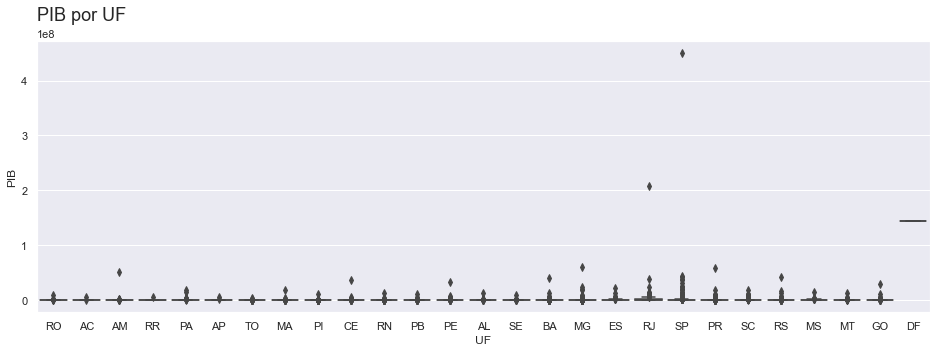

In [26]:
plt.figure(figsize=(16,5))
sns.boxplot(
    data=pib_municipio_df,
    y='PIB',
    x='UF')
plt.title('PIB por UF', size=18, loc='left', pad=20)
plt.show()

### `UF_Regiao`

In [27]:
uf_regiao.head()

,Estado,Regiao
0,Rondonia,N
1,Acre,N
2,Amazonas,N
3,Roraima,N
4,Para,N


In [28]:
uf_regiao.shape

(27, 2)

In [29]:
uf_regiao.describe()

,Estado,Regiao
count,27,27
unique,27,5
top,Rondonia,NE
freq,1,9


## Normalize data

### Create normalized dataframe from `Populacao_Estado`.

In [30]:
# Selecting Total will be more computationally efficient than grouping and summing values
norm_df = (
    populacao_estado_df
    .query('fx_idade == "Total"')
    .drop(columns='fx_idade')
    .sort_values('Granularidade')
    .reset_index(drop=True)
)

norm_df.head(6)

,Granularidade,Populacao
0,Acre,733559
1,Alagoas,3120494
2,Amapa,669526
3,Amazonas,3483985
4,Bahia,14016906
5,Brasil,190755799


In [31]:
# Store and remove Brasil row from norm_df
brasil_population = norm_df[norm_df['Granularidade']=='Brasil']['Populacao'].values
norm_df.dropna(inplace=True)
print(f'Brazilian total population: {brasil_population[0]}')

Brazilian total population: 190755799


### Merge with `uf_df`.

In [32]:
norm_df = pd.merge(
    left=norm_df,
    right=uf_df,
    on='Granularidade',
    how='left'
)

norm_df.head(6)

,Granularidade,Populacao,UF,Cod_Identificacao
0,Acre,733559,AC,12
1,Alagoas,3120494,AL,27
2,Amapa,669526,AP,16
3,Amazonas,3483985,AM,13
4,Bahia,14016906,BA,29
5,Brasil,190755799,NaN,NaN


In [33]:
# Drop NaNs
norm_df.dropna(inplace=True)

In [34]:
norm_df.describe(include='object').loc[['count', 'unique']]

,Granularidade,UF,Cod_Identificacao
count,27,27,27
unique,27,27,27


### Merge with `pib_municipio_df`.

In [35]:
pib_municipio_grouped_df = pib_municipio_df.groupby(['UF', 'Cod_Identificacao_uf'], as_index=False)['PIB'].sum()
pib_municipio_grouped_df.head()

,UF,Cod_Identificacao_uf,PIB
0,AC,12,8342356.0
1,AL,27,27133035.0
2,AM,13,60877125.0
3,AP,16,8237794.0
4,BA,29,154419544.0


In [36]:
norm_df = pd.merge(
    left=norm_df,
    right=pib_municipio_grouped_df,
    how='left',
    on='UF'
)

norm_df.head()

,Granularidade,Populacao,UF,Cod_Identificacao,Cod_Identificacao_uf,PIB
0,Acre,733559,AC,12,12,8342356.0
1,Alagoas,3120494,AL,27,27,27133035.0
2,Amapa,669526,AP,16,16,8237794.0
3,Amazonas,3483985,AM,13,13,60877125.0
4,Bahia,14016906,BA,29,29,154419544.0


In [37]:
# Checking if Cod_Identificacao matches
print('Checking if merged values from Cod_Identificacao matches.')
all(norm_df['Cod_Identificacao'] == norm_df['Cod_Identificacao_uf'])

Checking if merged values from Cod_Identificacao matches.


True

In [38]:
# Drop duplicated column
norm_df.drop(columns='Cod_Identificacao_uf', inplace=True)

### Merge with `uf_regiao`

In [39]:
uf_regiao.head()

,Estado,Regiao
0,Rondonia,N
1,Acre,N
2,Amazonas,N
3,Roraima,N
4,Para,N


In [40]:
norm_df = pd.merge(
    left=norm_df,
    right=uf_regiao,
    how='left',
    left_on='Granularidade',
    right_on='Estado',
    left_index=False
)

norm_df.head()

,Granularidade,Populacao,UF,Cod_Identificacao,PIB,Estado,Regiao
0,Acre,733559,AC,12,8342356.0,Acre,N
1,Alagoas,3120494,AL,27,27133035.0,Alagoas,NE
2,Amapa,669526,AP,16,8237794.0,Amapa,N
3,Amazonas,3483985,AM,13,60877125.0,Amazonas,N
4,Bahia,14016906,BA,29,154419544.0,Bahia,NE


In [41]:
# Reorder columns, dropping duplicated column "Granularidade"
norm_df = norm_df[[
    'Estado',
    'UF',
    'Regiao',
    'Cod_Identificacao',
    'Populacao',
    'PIB',
]]

In [42]:
# Map and replace values for "Regiao"
norm_df['Regiao'] = norm_df['Regiao'].map({
    'N' : 'Norte',
    'NE' : 'Nordeste',
    'S' : 'Sul',
    'SE' : 'Sudeste',
    'CO' : 'Centro-Oeste',
})

### Add `PIB_per_capita` feature

In [43]:
norm_df['PIB_per_capita'] = norm_df['PIB'] / norm_df['Populacao']

norm_df['PIB_per_capita'].describe()

count    27.000000
mean     17.171417
std      10.123858
min       7.043516
25%      11.032707
50%      14.737979
75%      20.431935
max      56.095380
Name: PIB_per_capita, dtype: float64

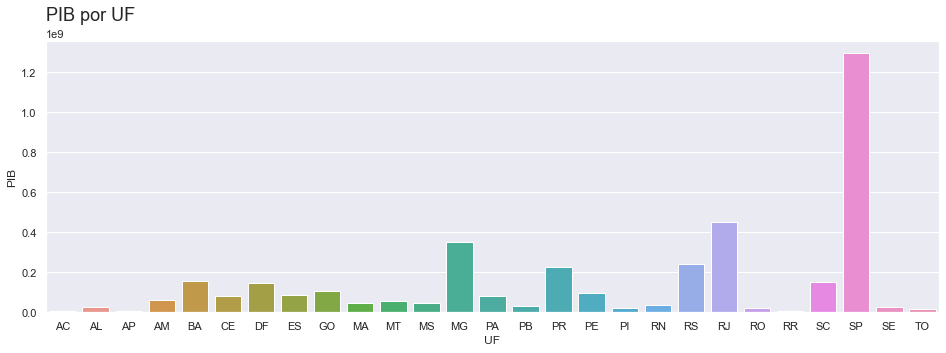

In [44]:
plt.figure(figsize=(16,5))
sns.barplot(data=norm_df, x='UF', y='PIB')
plt.title('PIB por UF', size=18, loc='left', pad=20)
plt.show()

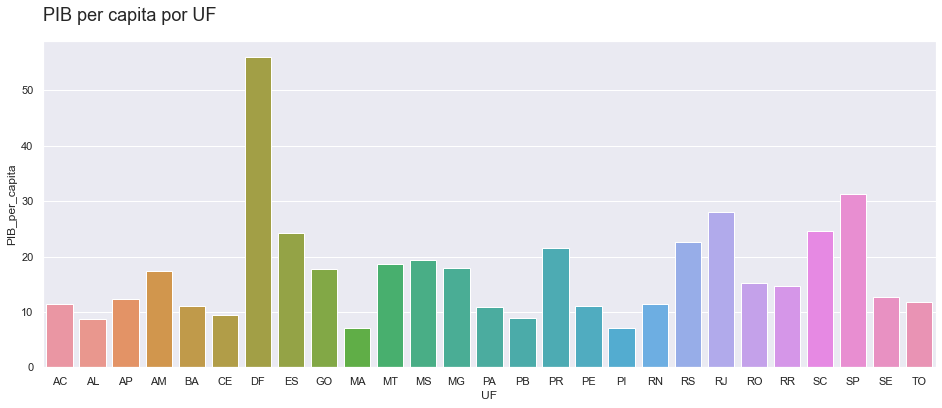

In [45]:
plt.figure(figsize=(16,6))
sns.barplot(data=norm_df, x='UF', y='PIB_per_capita')
plt.title('PIB per capita por UF', size=18, loc='left', pad=20)
plt.show()

## Results

In [46]:
# Total PIB
pib_total = norm_df['PIB'].sum() / brasil_population
pib_total

array([20.3707934])

In [47]:
# PIB per capita for each Macro region
(
norm_df
.groupby('Regiao', as_index=False)
['PIB_per_capita']
.sum().round(1)
.sort_values('Regiao')
.append({
    'PIB_per_capita' : pib_total[0].round(1),
    'Regiao' : 'Total',
}, ignore_index=True)
)

,Regiao,PIB_per_capita
0,Centro-Oeste,111.8
1,Nordeste,87.4
2,Norte,94.0
3,Sudeste,101.7
4,Sul,68.7
5,Total,20.4


In [48]:
session_info.show()